<a href="https://colab.research.google.com/github/martinpius/PYTORCH/blob/main/BackPropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from timeit import default_timer as timer
t1 = timer()
try:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount = True)
  import torch
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.model_selection import train_test_split
  from sklearn.datasets import make_blobs
  print(f">>>> You are on CoLaB with torch version: {torch.__version__}")
except Exception as e:
  print(f">>>> {type(e)}: {e}\n>>>> Please correct {type(e)} and reload")

def mytimer(t: float = timer())->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"hrs: {h}, mins: {m:>02}, secs: {s:>05.2f}"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f">>>> Available device: {device}")
!nvidia-smi
print(f">>>> Time elapsed:\t{mytimer(timer() - t1)}")


Mounted at /content/drive/
>>>> You are on CoLaB with torch version: 1.13.1+cu116
>>>> Available device: cpu
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

>>>> Time elapsed:	hrs: 0, mins: 00, secs: 08.00


* We implement the backpropagation algorithm for a simple MLP using numpy
Resources used for this notebook see: https://github.com/karpathy/micrograd/tree/master/micrograd and https://www.youtube.com/@AndrejKarpathy


In [5]:
class FeedforwardNet():
  """""
  @Author: Martin Pius
  ----------------------
  This class implement the FeedForward neural net
  with backprop from scratch using numpy for a classification
  problem.
  """""
  def __init__(self, X, y):
    self.beta = 1e-3
    self.m, self.n = X.shape
    self.LR = 1e-2
    self.h1 = 100
    self.h2 = len(np.unique(y))
    self.epochs = 10000
  
  def params_initializer(self, n0, n1):
    """""
    @Author: Martin Pius
    ----------------------
    This method initialize the parameters of the model
    Parameters:
    ----------------------
    n0: input size
    n1: hidden size
    W: Weights-> shape == [no, n1]
    b: bias -> shape == [1, n1]
    """""
    W = np.random.randn(n0, n1) * np.sqrt(2/n0)
    b = np.zeros((1, n1))
    return W, b
  
  def forwardpropagation(self, pars, X, y):
    """""
    @Author Martin Pius
    --------------------
    This method compute the forward pass for our network
    Parameters
    --------------------
    pars: Dictionary of weights and bias
    X: Input data ==> shape [m, n]
    Y: target vector --> shape [m,]
    """""
    # Unpacking the weights
    W1 = pars["W1"]
    W2 = pars["W2"]
    b1 = pars["b1"]
    b2 = pars["b2"]

    # The forward pass
    a0 = X
    Z1 = np.dot(a0, W1) + b1 # Linear layer [input]
    a1 = np.maximum(0, Z1) # ReLU-like layer
    Z2 = np.dot(a1, W2) + b2 # Linear layer [Output]
    expo = np.exp(Z2)
    probs = expo / np.sum(expo, axis = 1, keepdims = True) # The softmax layer
    # Cache components useful for backprop later
    cache = {"a0": a0, "a1": a1, "probs": probs}
    return cache, probs
  
  def criterion(self, pars, probs, y):
    """""
    @Author: Martin Pius
    ---------------------
    This module implement Cross entropy loss for multi-class problem
    We also use L_2 norm as to shrink the weight for better generalization
    
    Parameters:
    --------------------
    pars: Dictionary of weights
    y: target vector
    probs: predictions [Probs for the classes]
    """""
    W1 = pars["W1"]
    W2 = pars["W2"]
    self.m = len(y)
    # We only need to maximize the log of the correct class
    CE_loss = np.sum(-np.log(probs[np.arange(self.m), y]) / self.m)
    L2_reg = 0.5 * np.sum(W1 * W1)*self.beta + 0.5 * np.sum(W2 * W2)* self.beta 
    loss = CE_loss + L2_reg
    return loss
  
  def backpropagation(self, pars, cache, X, y):
    """""
    @Author: Martin Pius
    ---------------------
    This module employs the chain rule for differential
    calculus on vectors and matrices to compute the gradients
    Parameters:
    ---------------------
    pars: Dictionary of weights
    store: Dictionary of forwardprop outputs
    X: Input data matrix
    y: Target vactor
    We need to compute: dL/dw1, dL/dw2, dL/db1, dL/db2
    """""
    # Unpacking the weights
    W1 = pars["W1"]
    W2 = pars["W2"]
    b1 = pars["b1"]
    b2 = pars["b2"]

    #Unpacking the forwardprop outputs
    a0 = cache["a0"]
    a1 = cache["a1"]
    probs = cache["probs"]

    # Backward pass [Chain rule to compute the gradients]
    dz2 = probs
    dz2[np.arange(self.m), y]-=1
    dz2/=self.m # Grad of the loss wrt to the softmax layer
    # Compute the gradients of output layer before the softmax
    dw2 = np.dot(a1.T, dz2) + W2 * self.beta
    db2 = np.sum(dz2, axis = 0, keepdims = True)
    # Grads for the first layer[hidden layer]
    dz1 = np.dot(dz2, W2.T)
    dz1 = dz1* (a1 > 0) # backprop through the ReLU-like layer

    dw1 = np.dot(a0.T, dz1) + self.beta * W1
    db1 = np.sum(dz1, axis = 0, keepdims = True)
    # Pack the grads to use later in optimization
    grads = {"dw1": dw1, "dw2": dw2, "db1": db1, "db2": db2}

    return grads
  
  def gradient_descent(self, pars, grads):
    """""
    @Author: Martin Pius
    ---------------------
    This module implement parameters optimization via
    gradient descent
    Parameters:
    ----------------------
    pars: Dictionary of weights
    grads : Dictionary of gradients
    """""
    W1 = pars["W1"]
    W2 = pars["W2"]
    b1 = pars["b1"]
    b2 = pars["b2"]
    dw1 = grads["dw1"]
    dw2 = grads["dw2"]
    db1 = grads["db1"]
    db2 = grads["db2"]

    W1 -= self.LR * dw1
    W2 -= self.LR * dw2
    b1 -= self.LR * db1
    b2 -= self.LR * db2

    pars = {"W1": W1, "W2": W2, "b1": b1, "b2": b2}

    return pars

  def compute_accuracy(self, y, probs):
    """""
    @Author: Martin Pius
    ---------------------
    This module compute the accuracy of the classifier 
    Parameters:
    --------------
    y: Labels 
    probs: Class probabilities
    
    """""
    probs = np.argmax(probs, axis = 1) # Convert the class probs into labels
    acc = np.equal(probs, y).mean() # Compute the average accuracy
    
    return acc * 100

  def trainer(self, X_train, y_train):
    """""
    @Author: Martin Pius
    ---------------------
    This module train the neural net by combining the 
    above defined modules:
    Parameters:
    ---------------------
    X_train: input train data, shape [m, n]
    y_train: output label data, shape [m,]
    """""
    # Initialize and packing the weights into a dictionary
    W1, b1 = self.params_initializer(self.n, self.h1)
    W2, b2 = self.params_initializer(self.h1, self.h2)
    pars = {"W1": W1, "W2": W2, "b1": b1, "b2": b2}

    # Start training:
    for epoch in range(self.epochs + 1):

      # Forward pass call:
      cache, probs = self.forwardpropagation(pars, X_train, y_train)

      # Compute the loss:
      tr_loss = self.criterion(pars, probs, y_train)
      tr_acc = self.compute_accuracy(y_train, probs)

      # Backward pass: [backprop]:
      grads = self.backpropagation(pars, cache,X_train,y_train)

      # Gradient descent [stepping]:
      pars = self.gradient_descent(pars, grads)
      
      if epoch % 200 == 0:
        print(f"Epoch: {epoch + 1 if epoch == 0 else epoch}\
        \tTrain Loss: {tr_loss:.4f}\tTrain Accuracy: {tr_acc:.2f} %")

    return pars

  def validation(self, pars, X_test, y_test):
    """""
    @Author: Martin Pius
    --------------------
    This module compute the validation loss and accuracy
    to evaluate the model's performance on unseen data

    Parameters
    -------------------
    pars: Dictionary of the learned weights
    X_test: Test data[Unseen yet]
    y_test: Test label[Unseen yet]
    """""
    # We only run the forward prop: 
    cache, probs = self.forwardpropagation(pars, X_test, y_test)
    # Compute the testing loss
    val_loss = self.criterion(pars, probs, y_test)
    val_acc = self.compute_accuracy(y_test, probs)
    print(f"\n >>>> The performance of the network on unseed examples\
    \n >>>> Test loss is: {val_loss:.4f}\t Test accuracy is: {val_acc:.2f} %")
    self.decision_boundaries(X_test, y_test, pars)

  def decision_boundaries(self, X, y, pars):
    """""
    @Author: Martin Pius
    ---------------------
    This module plot the decision boundaries created by the 
    network to aid classification

    Parameters:
    ---------------------
    pars: A learned weight dictionary
    X: Input data, shape [m, n]
    y: output target shape [m,]
    """""
    # Grids boundary setup
    xx_min, xx_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    yy_min, yy_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # Create the grids points for the plot
    xx, xy = np.meshgrid(np.arange(xx_min, xx_max, 0.02), np.arange(yy_min, yy_max, 0.02))
    xx_data = np.c_[xx.ravel(), xy.ravel()] # Combine the data into a 2d array
    # Get the predictions of the xx_data
    _, probs = self.forwardpropagation(pars, xx_data, y) # Fetch the prediction probs
    labels = np.argmax(probs, axis = 1) # Get the predicted labels
    labels = labels.reshape(xx.shape) # Reshape into the same shape as datapoints arrays
    #plotting the contor map
    
    plt.figure(figsize = (12, 12))
    plt.contourf(xx, xy, labels, alpha = 0.85, cmap = plt.cm.RdYlBu)
    plt.scatter(X[:,0], X[:,1], s = 23, c = y, cmap = plt.cm.RdYlBu)
    plt.xlim(xx_min, xx_max)
    plt.ylim(yy_min, yy_max)
    plt.title("Decision boundary for the classification problem")



>>>> X_train shape: (7000, 2), y_train shape: (7000,)  
>>>> X_test shape: (3000, 2), y_test shape: (3000,)
Epoch: 1        	Train Loss: 17.8160	Train Accuracy: 19.79 %
Epoch: 200        	Train Loss: 0.1374	Train Accuracy: 98.61 %
Epoch: 400        	Train Loss: 0.1351	Train Accuracy: 98.61 %
Epoch: 600        	Train Loss: 0.1340	Train Accuracy: 98.60 %
Epoch: 800        	Train Loss: 0.1333	Train Accuracy: 98.60 %
Epoch: 1000        	Train Loss: 0.1327	Train Accuracy: 98.60 %
Epoch: 1200        	Train Loss: 0.1322	Train Accuracy: 98.60 %
Epoch: 1400        	Train Loss: 0.1317	Train Accuracy: 98.60 %
Epoch: 1600        	Train Loss: 0.1312	Train Accuracy: 98.60 %
Epoch: 1800        	Train Loss: 0.1308	Train Accuracy: 98.60 %
Epoch: 2000        	Train Loss: 0.1304	Train Accuracy: 98.61 %
Epoch: 2200        	Train Loss: 0.1300	Train Accuracy: 98.61 %
Epoch: 2400        	Train Loss: 0.1295	Train Accuracy: 98.61 %
Epoch: 2600        	Train Loss: 0.1291	Train Accuracy: 98.61 %
Epoch: 2800     

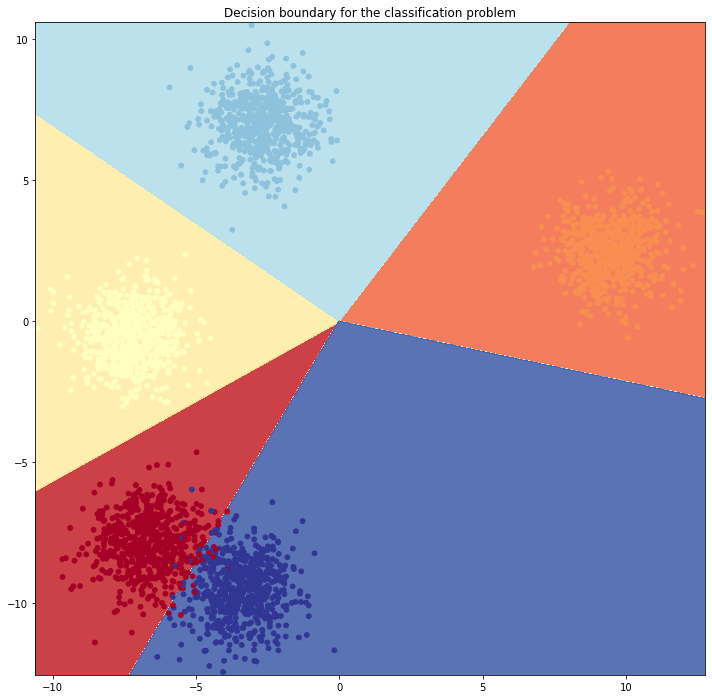

In [6]:
if __name__ == "__main__":
  tic = timer()
  X, y = make_blobs(n_samples = 10000, n_features = 2, centers = 5)
  y = y.astype(int)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  print(f">>>> X_train shape: {X_train.shape}, y_train shape: {y_train.shape}\
  \n>>>> X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
  model = FeedforwardNet(X_train, y_train)
  pars = model.trainer(X_train, y_train)
  model.validation(pars, X_test, y_test)
  toc = timer()
  print(f">>>> Tottal time elapsed: {mytimer(toc - tic)}") 